In [1]:
# Setup — load clean data & re-split
import pandas as pd
import numpy as np

from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
confusion_matrix, classification_report, roc_auc_score, roc_curve, 
precision_recall_curve, average_precision_score, accuracy_score, precision_score, recall_score, f1_score)
import matplotlib.pyplot as plt

df = pd.read_csv("data/titanic_clean.csv")

X = pd.get_dummies(df.drop("survived", axis=1), drop_first=True)
y = df["survived"].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.mean(), y_test.mean()
                                          

((712, 9),
 (179, 9),
 np.float64(0.38342696629213485),
 np.float64(0.3854748603351955))

In [3]:
# Fit baseline Logistic Regression & Random Forest
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)

rf = RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=1)
rf.fit(X_train, y_train)

y_pred_lr = logreg.predict(X_test)
y_proba_lr = logreg.predict_proba(X_test)[:, 1]

y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]

=== Logistic Regression ===


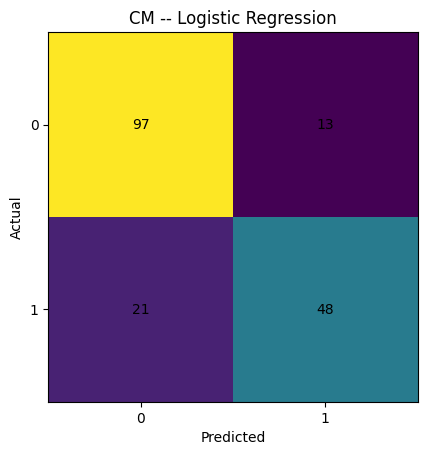

              precision    recall  f1-score   support

           0      0.822     0.882     0.851       110
           1      0.787     0.696     0.738        69

    accuracy                          0.810       179
   macro avg      0.804     0.789     0.795       179
weighted avg      0.808     0.810     0.808       179

=== Random Forest ===


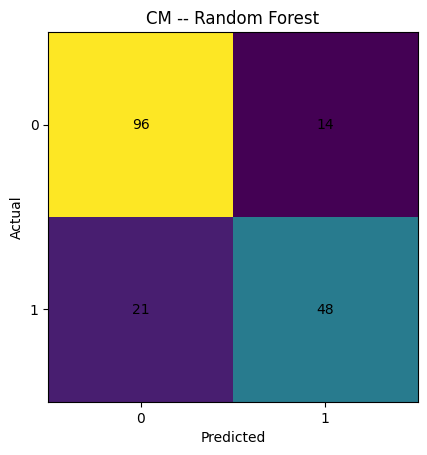

              precision    recall  f1-score   support

           0      0.821     0.873     0.846       110
           1      0.774     0.696     0.733        69

    accuracy                          0.804       179
   macro avg      0.797     0.784     0.789       179
weighted avg      0.803     0.804     0.802       179



In [6]:
# Confusion Matrix + per-class report (LogReg & RF)
def plot_cm(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots()
    im = ax.imshow(cm)
    ax.set_title(title)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    ax.set_xticks([0,1]); ax.set_yticks([0,1])
    for (i, j), v in np.ndenumerate(cm):
        ax.text(j, i, str(v), ha="center", va="center")
    plt.show()
    return cm

print ("=== Logistic Regression ===")
cm_lr = plot_cm(y_test, y_pred_lr, "CM -- Logistic Regression")
print(classification_report(y_test, y_pred_lr, digits=3))

print ("=== Random Forest ===")
cm_lr = plot_cm(y_test, y_pred_rf, "CM -- Random Forest")
print(classification_report(y_test, y_pred_rf, digits=3))


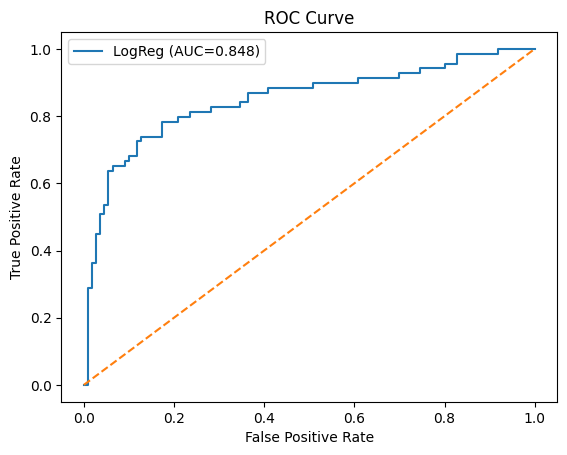

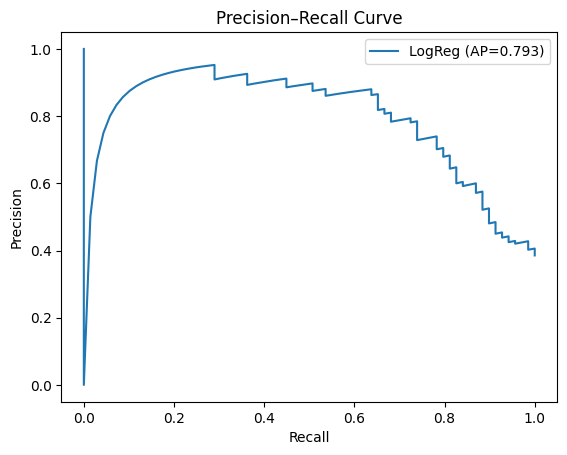

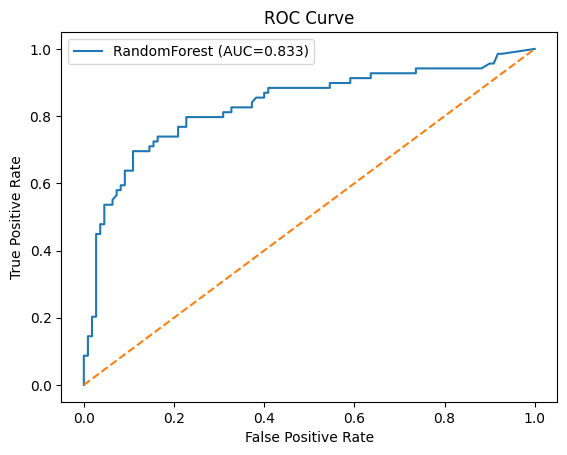

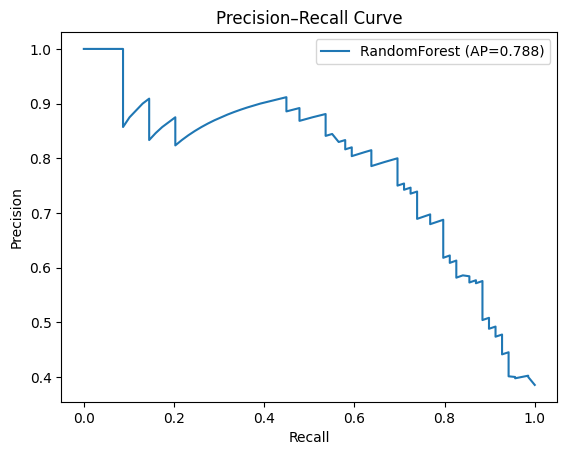

,AUC,AP
LogReg,0.848,0.793
RandomForest,0.833,0.788


In [7]:
# ROC curve & AUC; Precision–Recall curve & Accurate Precision score (AP)
def plot_roc_pr(y_true, y_proba, label="model"):
    # ROC
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    auc = roc_auc_score(y_true, y_proba)
    fig = plt.figure()
    plt.plot(fpr, tpr, label=f"{label} (AUC={auc:.3f})")
    plt.plot([0,1],[0,1], linestyle="--")
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.title("ROC Curve"); plt.legend(); plt.show()

    # PR
    prec, rec, _ = precision_recall_curve(y_true, y_proba)
    ap = average_precision_score(y_true, y_proba)
    fig = plt.figure()
    plt.plot(rec, prec, label=f"{label} (AP={ap:.3f})")
    plt.xlabel("Recall"); plt.ylabel("Precision")
    plt.title("Precision–Recall Curve"); plt.legend(); plt.show()
    return auc, ap

auc_lr, ap_lr = plot_roc_pr(y_test, y_proba_lr, "LogReg")
auc_rf, ap_rf = plot_roc_pr(y_test, y_proba_rf, "RandomForest")

pd.DataFrame(
    {"AUC": [auc_lr, auc_rf], "AP": [ap_lr, ap_rf]},
    index=["LogReg", "RandomForest"]
).round(3)